In [1]:
from IPython.display import clear_output
from typing import List, Optional

import datetime
import gpflow as gpf
import hydra
import matplotlib.pyplot as plt
import numpy as np
import os
import palettable
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import cm
from modeopt.custom_types import Dataset
from modeopt.utils import model_from_DictConfig
from modeopt.mode_opt import ModeOpt
from mogpe.keras.callbacks.tensorboard import PlotFn, TensorboardImageCallback
from mogpe.keras.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.keras.plotting import MixtureOfSVGPExpertsContourPlotter
from mogpe.keras.utils import sample_mosvgpe_inducing_inputs_from_data, model_from_yaml
from numpy import random
from omegaconf import DictConfig
from simenvs import make

tfd = tfp.distributions

CMAP = palettable.scientific.sequential.Bilbao_15.mpl_colormap

meaning_of_life = 42
tf.random.set_seed(meaning_of_life)
np.random.seed(meaning_of_life)

In [2]:
env_name = "velocity-controlled-point-mass/scenario-5"
start_state = np.array([2.5, -1.2])
target_state = np.array([-3.0, 2.5])
env_name = "velocity-controlled-point-mass/scenario-7"
target_state = np.array([1.7, 3.0])
start_state = np.array([-1.0, -2.0])
num_initial_states = 30

In [3]:
# mode_satisfaction_prob = 0.8
mode_satisfaction_prob = 0.85
# mode_satisfaction_prob = 0.4

In [13]:
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M') #  now
save_dir = os.path.join("./images/bayesian_optimisation/", str(mode_satisfaction_prob))
save_dir = os.path.join(save_dir, now_time)
os.makedirs(save_dir)

In [5]:
initial_num_epochs = 1300
num_epochs = 150
batch_size = 16

In [6]:
env = make(env_name)
state_dim = env.observation_spec().shape[0]

No constant_error found in toml config so using default : 0.0


In [7]:
def get_initial_states(start_state, target_state, width):
    return random.uniform([start_state[0]-width, start_state[1]-width],
                                   [start_state[0]+width, start_state[1]+width],
                                    (num_initial_states, state_dim))
initial_states = get_initial_states(start_state, target_state, width=1.0)
# initial_states = random.uniform([2, -2], [3, -1], (num_initial_states, state_dim))

In [8]:
yaml_cfg_filename = "./velocity_controlled_point_mass/notebooks/keras_configs/dynamics.yaml"
# yaml_cfg_filename = "./notebooks/keras_configs/dynamics.yaml"
yaml_cfg_filename = "./keras_configs/dynamics.yaml"
mode_optimiser = model_from_yaml(yaml_cfg_filename, custom_objects={"ModeOpt": ModeOpt})

2022-02-27 15:20:11.724248: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


╒════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤════════════════════════════════════════╕
│ name                                                           │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value                                  │
╞════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪════════════════════════════════════════╡
│ IndependentPosteriorMultiOutput.kernel.kernels[0].variance     │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.0                                    │
├────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼────────────────────────────────────────┤
│ IndependentPosteriorMultiOutput.kernel.kernels[0].lengthscales │ Paramete

2022-02-27 15:20:12.118861: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-27 15:20:12.118912: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-27 15:20:12.118977: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [9]:
def sample_env_at_states(states, num_actions=5, verbose=False):
    delta_state_outputs = []
    state_control_inputs = []
    for state in states:
        for i in range(num_actions):
            action = np.random.uniform(env.action_spec().minimum, 
                                       env.action_spec().maximum, 
                                       (env.action_spec().shape[-1]))
            delta_state = env.transition_dynamics(state, action)
            delta_state_outputs.append(delta_state)
            state_control_input = np.concatenate([state, action], -1)
            state_control_inputs.append(state_control_input)
    delta_state_outputs = np.stack(delta_state_outputs)
    state_control_inputs = np.stack(state_control_inputs)
    if verbose:
        print("State control inputs: ", state_control_inputs.shape)
        print("Delta state outputs: ", delta_state_outputs.shape)
    return state_control_inputs, delta_state_outputs

initial_dataset = sample_env_at_states(initial_states, verbose=True)
dataset = initial_dataset

State control inputs:  (150, 4)
Delta state outputs:  (150, 2)


In [10]:
mode_optimiser.dataset = initial_dataset
sample_mosvgpe_inducing_inputs_from_data(initial_dataset[0], mode_optimiser.dynamics.mosvgpe)
num_experts = mode_optimiser.dynamics.mosvgpe.num_experts

In [11]:
def create_test_inputs(
    x_min=[-3, -3], x_max=[3, 3], input_dim=4, num_test: int = 400, factor: float = 1.2
):
    sqrtN = int(np.sqrt(num_test))
    xx = np.linspace(x_min[0] * factor, x_max[0] * factor, sqrtN)
    yy = np.linspace(x_min[1] * factor, x_max[1] * factor, sqrtN)
    xx, yy = np.meshgrid(xx, yy)
    test_inputs = np.column_stack([xx.reshape(-1), yy.reshape(-1)])
    if input_dim > 2:
        zeros = np.zeros((num_test, input_dim - 2))
        test_inputs = np.concatenate([test_inputs, zeros], -1)
    return test_inputs, xx, yy
test_inputs, xx, yy = create_test_inputs()

In [12]:
def plot_states(ax, states):
    ax.scatter(states[:, 0], states[:, 1], marker='x', color='b', alpha=0.4, label="Observations")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_xlim([-3.5, 3.5])
    ax.set_ylim([-3.5, 3.5])
    ax.scatter(start_state[0], start_state[1], color="k", marker="s")
    ax.scatter(target_state[0], target_state[1], color="k", marker="s")
    ax.annotate("$\mathbf{x}_0$", (start_state[0] + 0.1, start_state[1]))
    ax.annotate("$\mathbf{x}_f$", (target_state[0] - 0.35, target_state[1]))

# def plot_gating_network_gps(states):
#     fig = plt.figure(figsize=(15,10))
#     gs = fig.add_gridspec(num_experts, 2, wspace=0.3)
#     axs = gs.subplots(sharex=True, sharey=True)
#     fig.suptitle("Gating GPs")
#     h_means, h_vars = mode_optimiser.dynamics.mosvgpe.gating_network.predict_h(test_inputs)
#     mixing_probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(test_inputs)
#     delta_mode_inputs = test_inputs[mixing_probs[:, desired_mode]>mode_satisfaction_prob]
#     print(delta_mode_inputs.shape)
#     for k in range(num_experts):
#         axs[k, 0].tricontourf(test_inputs[:, 0], test_inputs[:, 1], h_means[:, k], cmap=CMAP)
#         axs[k, 1].tricontourf(test_inputs[:, 0], test_inputs[:, 1], h_vars[:, k], cmap=CMAP)
#         for ax in axs[k, :].flat:
#             CS = ax.contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
#             ax.clabel(CS, inline=True, fontsize=10)
#     for ax in axs.flat:
# #         ax.tricontourf(delta_mode_inputs[:, 0], 
# #                        delta_mode_inputs[:, 1], 
# #                        np.zeros(delta_mode_inputs.shape[0]), 
# #                        cmap=cm.PiYG)
#         plot_states(ax, states)

# plot_gating_network_gps(initial_states)

/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_28800/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_28800/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_28800/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_28800/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.sha

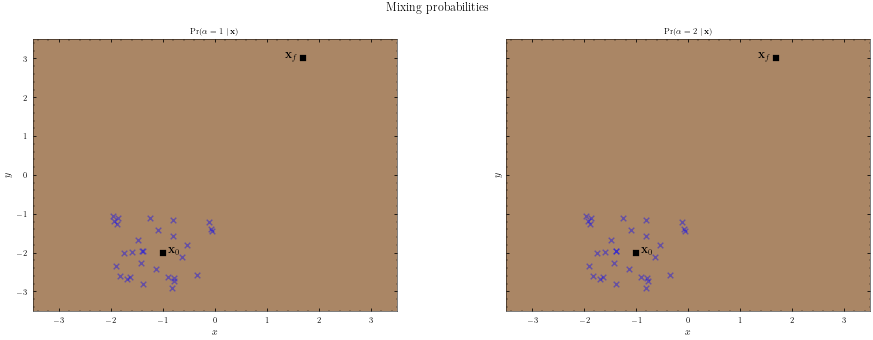

In [14]:
def plot_mixing_probs(states):
    fig = plt.figure(figsize=(15,5))
    fig.suptitle("Mixing probabilities")
    gs = fig.add_gridspec(1, num_experts, wspace=0.3)
    axs = gs.subplots(sharex=True, sharey=True)
    mixing_probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(test_inputs)
    for k in range(num_experts):
        axs[k].tricontourf(test_inputs[:, 0], test_inputs[:, 1], mixing_probs[:, k], cmap=CMAP)
        CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
        axs[k].clabel(CS, inline=True, fontsize=10)
        axs[k].set_title("$\Pr(\\alpha=" + str(k + 1) + " \mid \mathbf{x})$")
        plot_states(axs[k], states)

plot_mixing_probs(initial_states)
# plt.savefig("./velocity_controlled_point_mass/notebooks/images/initial_mixing_probs.pdf", transparent=True)
plt.savefig(os.path.join(save_dir, "initial_mixing_probs_before_training.pdf"), transparent=True)

In [15]:
mode_optimiser.dynamics.fit(initial_dataset[0], initial_dataset[1], epochs=initial_num_epochs, batch_size=batch_size)
initial_mosvgpe = MixtureOfSVGPExperts.from_config(mode_optimiser.dynamics.mosvgpe.get_config())

2022-02-27 15:20:40.016154: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1300
Mixing probs: (1, None, 2)
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Experts probs: (None, None, 2)


2022-02-27 15:20:48.288368: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Mixing probs: (1, None, 2)
Experts probs: (None, None, 2)
10/10 [==============================] - 44s 16ms/step - loss: 30265446.5815
Epoch 2/1300
10/10 [==============================] - 0s 17ms/step - loss: 18433705.1154
Epoch 3/1300
10/10 [==============================] - 0s 15ms/step - loss: 10987357.4298
Epoch 4/1300
10/10 [==============================] - 0s 16ms/step - loss: 6277654.6646
Epoch 5/1300
10/10 [==============================] - 0s 15ms/step - loss: 3499440.6408
Epoch 6/1300
10/10 [==============================] - 0s 15ms/step - loss: 1961879.3484
Epoch 7/1300
10/10 [==============================] - 0s 14ms/step - loss: 1130301.1821
Epoch 8/1300
10/10 [==============================] - 0s 14ms/step - loss: 662174.5848
Epoch 9/1300
10/10 [==============================] - 0s 14ms/step - loss: 399125.6105
Epoch 10/1300
10/10 [==============================] - 0s 14ms/step - loss: 254649.7455
Epoch 11/1300
10/10 [==============================] - 0s 15ms/step - los

Epoch 93/1300
10/10 [==============================] - 0s 17ms/step - loss: 1610.3381
Epoch 94/1300
10/10 [==============================] - 0s 18ms/step - loss: 1606.7180
Epoch 95/1300
10/10 [==============================] - 0s 18ms/step - loss: 1605.0548
Epoch 96/1300
10/10 [==============================] - 0s 18ms/step - loss: 1574.0182
Epoch 97/1300
10/10 [==============================] - 0s 17ms/step - loss: 1501.7559
Epoch 98/1300
10/10 [==============================] - 0s 18ms/step - loss: 1513.6855
Epoch 99/1300
10/10 [==============================] - 0s 18ms/step - loss: 1481.1186
Epoch 100/1300
10/10 [==============================] - 0s 17ms/step - loss: 1438.8726
Epoch 101/1300
10/10 [==============================] - 0s 17ms/step - loss: 1422.9075
Epoch 102/1300
10/10 [==============================] - 0s 17ms/step - loss: 1375.5123
Epoch 103/1300
10/10 [==============================] - 0s 16ms/step - loss: 1373.5846
Epoch 104/1300
10/10 [============================

10/10 [==============================] - 0s 19ms/step - loss: 595.3233
Epoch 188/1300
10/10 [==============================] - 0s 18ms/step - loss: 572.1651
Epoch 189/1300
10/10 [==============================] - 0s 19ms/step - loss: 575.5585
Epoch 190/1300
10/10 [==============================] - 0s 19ms/step - loss: 577.9137
Epoch 191/1300
10/10 [==============================] - 0s 20ms/step - loss: 556.0339
Epoch 192/1300
10/10 [==============================] - 0s 18ms/step - loss: 562.6669
Epoch 193/1300
10/10 [==============================] - 0s 18ms/step - loss: 572.1811
Epoch 194/1300
10/10 [==============================] - 0s 18ms/step - loss: 528.3516
Epoch 195/1300
10/10 [==============================] - 0s 17ms/step - loss: 506.5025
Epoch 196/1300
10/10 [==============================] - 0s 17ms/step - loss: 513.7009
Epoch 197/1300
10/10 [==============================] - 0s 20ms/step - loss: 545.7463
Epoch 198/1300
10/10 [==============================] - 0s 16ms/step 

10/10 [==============================] - 0s 31ms/step - loss: 250.8154
Epoch 283/1300
10/10 [==============================] - 0s 25ms/step - loss: 243.5180
Epoch 284/1300
10/10 [==============================] - 0s 21ms/step - loss: 268.0508
Epoch 285/1300
10/10 [==============================] - 0s 20ms/step - loss: 243.2837
Epoch 286/1300
10/10 [==============================] - 0s 20ms/step - loss: 253.5374
Epoch 287/1300
10/10 [==============================] - 0s 22ms/step - loss: 263.5043
Epoch 288/1300
10/10 [==============================] - 0s 20ms/step - loss: 243.6340
Epoch 289/1300
10/10 [==============================] - 0s 20ms/step - loss: 244.2438
Epoch 290/1300
10/10 [==============================] - 0s 21ms/step - loss: 264.8892
Epoch 291/1300
10/10 [==============================] - 0s 22ms/step - loss: 267.7005
Epoch 292/1300
10/10 [==============================] - 0s 20ms/step - loss: 240.0372
Epoch 293/1300
10/10 [==============================] - 0s 22ms/step 

10/10 [==============================] - 0s 20ms/step - loss: 118.3683
Epoch 378/1300
10/10 [==============================] - 0s 24ms/step - loss: 86.2296
Epoch 379/1300
10/10 [==============================] - 0s 20ms/step - loss: 77.4801
Epoch 380/1300
10/10 [==============================] - 0s 22ms/step - loss: 68.3394
Epoch 381/1300
10/10 [==============================] - 0s 22ms/step - loss: 85.4812
Epoch 382/1300
10/10 [==============================] - 0s 22ms/step - loss: 65.5881
Epoch 383/1300
10/10 [==============================] - 0s 22ms/step - loss: 64.1489
Epoch 384/1300
10/10 [==============================] - 0s 20ms/step - loss: 66.7868
Epoch 385/1300
10/10 [==============================] - 0s 22ms/step - loss: 103.1781
Epoch 386/1300
10/10 [==============================] - 0s 20ms/step - loss: 83.3781
Epoch 387/1300
10/10 [==============================] - 0s 20ms/step - loss: 93.5537
Epoch 388/1300
10/10 [==============================] - 0s 20ms/step - loss: 6

10/10 [==============================] - 0s 17ms/step - loss: -45.1270
Epoch 474/1300
10/10 [==============================] - 0s 18ms/step - loss: -4.8056
Epoch 475/1300
10/10 [==============================] - 0s 18ms/step - loss: -12.4497
Epoch 476/1300
10/10 [==============================] - 0s 18ms/step - loss: -16.6331
Epoch 477/1300
10/10 [==============================] - 0s 18ms/step - loss: -27.3283
Epoch 478/1300
10/10 [==============================] - 0s 18ms/step - loss: -27.5378
Epoch 479/1300
10/10 [==============================] - 0s 18ms/step - loss: -58.0282
Epoch 480/1300
10/10 [==============================] - 0s 18ms/step - loss: -47.7413
Epoch 481/1300
10/10 [==============================] - 0s 18ms/step - loss: -69.3704
Epoch 482/1300
10/10 [==============================] - 0s 18ms/step - loss: -67.8551
Epoch 483/1300
10/10 [==============================] - 0s 18ms/step - loss: -53.0384
Epoch 484/1300
10/10 [==============================] - 0s 18ms/step -

10/10 [==============================] - 0s 21ms/step - loss: -160.4846
Epoch 569/1300
10/10 [==============================] - 0s 20ms/step - loss: -110.5795
Epoch 570/1300
10/10 [==============================] - 0s 22ms/step - loss: -104.2866
Epoch 571/1300
10/10 [==============================] - 0s 21ms/step - loss: -62.7310
Epoch 572/1300
10/10 [==============================] - 0s 21ms/step - loss: -119.3435
Epoch 573/1300
10/10 [==============================] - 0s 20ms/step - loss: -144.7158
Epoch 574/1300
10/10 [==============================] - 0s 21ms/step - loss: -127.5681
Epoch 575/1300
10/10 [==============================] - 0s 20ms/step - loss: -166.5452
Epoch 576/1300
10/10 [==============================] - 0s 20ms/step - loss: -171.0877
Epoch 577/1300
10/10 [==============================] - 0s 20ms/step - loss: -178.5429
Epoch 578/1300
10/10 [==============================] - 0s 22ms/step - loss: -120.2103
Epoch 579/1300
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 17ms/step - loss: -252.7939
Epoch 663/1300
10/10 [==============================] - 0s 17ms/step - loss: -235.3732
Epoch 664/1300
10/10 [==============================] - 0s 16ms/step - loss: -257.7538
Epoch 665/1300
10/10 [==============================] - 0s 16ms/step - loss: -251.9307
Epoch 666/1300
10/10 [==============================] - 0s 16ms/step - loss: -204.1572
Epoch 667/1300
10/10 [==============================] - 0s 16ms/step - loss: -183.5629
Epoch 668/1300
10/10 [==============================] - 0s 17ms/step - loss: -139.5765
Epoch 669/1300
10/10 [==============================] - 0s 17ms/step - loss: -185.4562
Epoch 670/1300
10/10 [==============================] - 0s 17ms/step - loss: -251.6580
Epoch 671/1300
10/10 [==============================] - 0s 17ms/step - loss: -265.1468
Epoch 672/1300
10/10 [==============================] - 0s 16ms/step - loss: -291.3762
Epoch 673/1300
10/10 [==============================] - 0s

10/10 [==============================] - 0s 15ms/step - loss: -305.7653
Epoch 757/1300
10/10 [==============================] - 0s 14ms/step - loss: -328.8885
Epoch 758/1300
10/10 [==============================] - 0s 14ms/step - loss: -276.9154
Epoch 759/1300
10/10 [==============================] - 0s 16ms/step - loss: -330.7357
Epoch 760/1300
10/10 [==============================] - 0s 15ms/step - loss: -236.6257
Epoch 761/1300
10/10 [==============================] - 0s 14ms/step - loss: -280.0704
Epoch 762/1300
10/10 [==============================] - 0s 13ms/step - loss: -296.8591
Epoch 763/1300
10/10 [==============================] - 0s 14ms/step - loss: -334.3520
Epoch 764/1300
10/10 [==============================] - 0s 15ms/step - loss: -336.1182
Epoch 765/1300
10/10 [==============================] - 0s 16ms/step - loss: -365.9690
Epoch 766/1300
10/10 [==============================] - 0s 14ms/step - loss: -338.9157
Epoch 767/1300
10/10 [==============================] - 0s

10/10 [==============================] - 0s 17ms/step - loss: -180.8955
Epoch 851/1300
10/10 [==============================] - 0s 17ms/step - loss: -127.4582
Epoch 852/1300
10/10 [==============================] - 0s 17ms/step - loss: -231.4071
Epoch 853/1300
10/10 [==============================] - 0s 16ms/step - loss: -191.5907
Epoch 854/1300
10/10 [==============================] - 0s 18ms/step - loss: -223.9826
Epoch 855/1300
10/10 [==============================] - 0s 17ms/step - loss: -230.0240
Epoch 856/1300
10/10 [==============================] - 0s 19ms/step - loss: -206.1179
Epoch 857/1300
10/10 [==============================] - 0s 18ms/step - loss: -252.0986
Epoch 858/1300
10/10 [==============================] - 0s 17ms/step - loss: -194.3667
Epoch 859/1300
10/10 [==============================] - 0s 16ms/step - loss: -191.9160
Epoch 860/1300
10/10 [==============================] - 0s 18ms/step - loss: -246.7307
Epoch 861/1300
10/10 [==============================] - 0s

10/10 [==============================] - 0s 20ms/step - loss: -317.8849
Epoch 945/1300
10/10 [==============================] - 0s 19ms/step - loss: -345.6629
Epoch 946/1300
10/10 [==============================] - 0s 20ms/step - loss: -347.4600
Epoch 947/1300
10/10 [==============================] - 0s 19ms/step - loss: -342.0801
Epoch 948/1300
10/10 [==============================] - 0s 19ms/step - loss: -332.8441
Epoch 949/1300
10/10 [==============================] - 0s 18ms/step - loss: -403.5070
Epoch 950/1300
10/10 [==============================] - 0s 19ms/step - loss: -413.3248
Epoch 951/1300
10/10 [==============================] - 0s 19ms/step - loss: -434.8839
Epoch 952/1300
10/10 [==============================] - 0s 19ms/step - loss: -406.0571
Epoch 953/1300
10/10 [==============================] - 0s 18ms/step - loss: -409.1429
Epoch 954/1300
10/10 [==============================] - 0s 19ms/step - loss: -425.0279
Epoch 955/1300
10/10 [==============================] - 0s

10/10 [==============================] - 0s 19ms/step - loss: -416.8900
Epoch 1038/1300
10/10 [==============================] - 0s 19ms/step - loss: -425.3390
Epoch 1039/1300
10/10 [==============================] - 0s 51ms/step - loss: -470.2338
Epoch 1040/1300
10/10 [==============================] - 0s 25ms/step - loss: -390.2767
Epoch 1041/1300
10/10 [==============================] - 0s 25ms/step - loss: -355.0504
Epoch 1042/1300
10/10 [==============================] - 0s 37ms/step - loss: -240.5820
Epoch 1043/1300
10/10 [==============================] - 0s 46ms/step - loss: -297.1395
Epoch 1044/1300
10/10 [==============================] - 0s 26ms/step - loss: -368.2739
Epoch 1045/1300
10/10 [==============================] - 0s 34ms/step - loss: -372.2063
Epoch 1046/1300
10/10 [==============================] - 0s 27ms/step - loss: -414.8757
Epoch 1047/1300
10/10 [==============================] - 0s 37ms/step - loss: -362.7748
Epoch 1048/1300
10/10 [=========================

10/10 [==============================] - 0s 21ms/step - loss: -439.7742
Epoch 1131/1300
10/10 [==============================] - 0s 20ms/step - loss: -447.5385
Epoch 1132/1300
10/10 [==============================] - 0s 22ms/step - loss: -451.1288
Epoch 1133/1300
10/10 [==============================] - 0s 19ms/step - loss: -418.6275
Epoch 1134/1300
10/10 [==============================] - 0s 19ms/step - loss: -417.3746
Epoch 1135/1300
10/10 [==============================] - 0s 20ms/step - loss: -429.2970
Epoch 1136/1300
10/10 [==============================] - 0s 20ms/step - loss: -439.2444
Epoch 1137/1300
10/10 [==============================] - 0s 18ms/step - loss: -403.6601
Epoch 1138/1300
10/10 [==============================] - 0s 25ms/step - loss: -430.7008
Epoch 1139/1300
10/10 [==============================] - 0s 20ms/step - loss: -416.7696
Epoch 1140/1300
10/10 [==============================] - 0s 18ms/step - loss: -441.6813
Epoch 1141/1300
10/10 [=========================

10/10 [==============================] - 0s 17ms/step - loss: -376.6160
Epoch 1224/1300
10/10 [==============================] - 0s 16ms/step - loss: -367.2174
Epoch 1225/1300
10/10 [==============================] - 0s 16ms/step - loss: -398.4084
Epoch 1226/1300
10/10 [==============================] - 0s 16ms/step - loss: -449.5080
Epoch 1227/1300
10/10 [==============================] - 0s 17ms/step - loss: -430.1593
Epoch 1228/1300
10/10 [==============================] - 0s 15ms/step - loss: -478.8276
Epoch 1229/1300
10/10 [==============================] - 0s 16ms/step - loss: -490.1644
Epoch 1230/1300
10/10 [==============================] - 0s 16ms/step - loss: -512.2110
Epoch 1231/1300
10/10 [==============================] - 0s 18ms/step - loss: -512.5429
Epoch 1232/1300
10/10 [==============================] - 0s 16ms/step - loss: -483.5965
Epoch 1233/1300
10/10 [==============================] - 0s 15ms/step - loss: -428.0063
Epoch 1234/1300
10/10 [=========================

In [16]:
# mode_optimiser.dynamics.mosvgpe = initial_mosvgpe
gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)

In [17]:
def which_desired_mode(mode_optimiser, initial_dataset):
    probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(initial_dataset[0])
    mean_probs = tf.reduce_mean(probs, 0)
    return int(tf.math.argmax(mean_probs))

desired_mode = which_desired_mode(mode_optimiser, initial_dataset)
print("Desired mode is {}".format(desired_mode))

Desired mode is 0


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


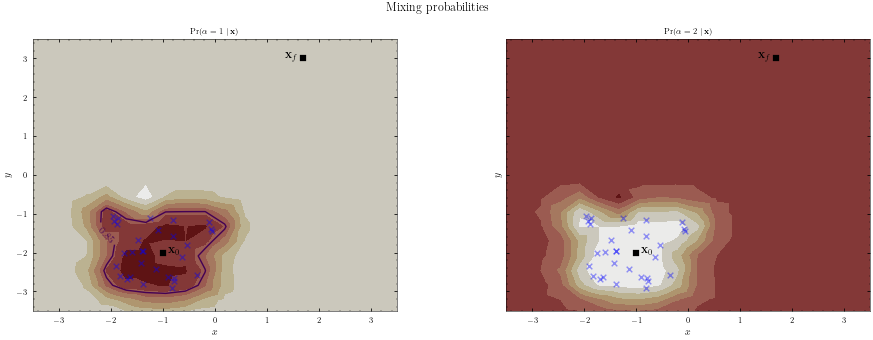

In [18]:
plot_mixing_probs(initial_states)
# plt.savefig("./images/initial_mixing_probs.pdf", transparent=True)
plt.savefig(os.path.join(save_dir, "initial_mixing_prob.pdf"), transparent=True)
# plt.savefig("./velocity_controlled_point_mass/notebooks/images/initial_mixing_probs.pdf", transparent=True)

In [17]:
def sample_delta_mode_states(num_states_to_sample=100, delta_mode_prob=0.8, num_initial_samples=10):
    delta_mode_states = random.uniform([-4, -4], [4, 4], (num_initial_samples, state_dim))
    while delta_mode_states.shape[0] < num_states_to_sample:
        delta_mode_states = random.uniform([-4, -4], [4, 4], (num_initial_samples, state_dim))
        mixing_probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(delta_mode_states)
        delta_mode_states = delta_mode_states[mixing_probs[:, desired_mode]>delta_mode_prob, :]
        num_initial_samples = num_initial_samples * 2
        if delta_mode_states.shape[0] == 0:
            delta_mode_prob -= 0.05
            print("Mode satisfaction probability being relaxed to {}".format(delta_mode_prob))
    return delta_mode_states[:num_states_to_sample, :]

def sample_delta_mode_remaining_state_control_inputs(dataset, 
                                                     delta_mode_prob, 
                                                     previous_mosvgpe=None, 
                                                     num_states_to_sample=100):
    X, Y = dataset 
    states = X[:, :state_dim]
    delta_mode_states = sample_delta_mode_states(num_states_to_sample, delta_mode_prob)
    if previous_mosvgpe is None:
        mask_x_min = delta_mode_states[:, 0]<states[:, 0].min(0) 
        mask_x_max = delta_mode_states[:, 0]>states[:, 0].max(0)
        mask_y_min = delta_mode_states[:, 1]<states[:, 1].min(0) 
        mask_y_max = delta_mode_states[:, 1]>states[:, 1].max(0)
        mask = mask_x_min | mask_x_max | mask_y_min | mask_y_max
    else:
        mask = previous_mosvgpe.gating_network.predict_mixing_probs(delta_mode_states)[:, desired_mode] > delta_mode_prob
#         print(mask)
#         print(mask.shape)
    delta_mode_states_keep = delta_mode_states[mask]
#     print(delta_mode_states_keep.shape)
    new_dataset = sample_env_at_states(delta_mode_states_keep)
    return new_dataset

In [ ]:
# Setup input domain
import gpflowopt
domain = gpflowopt.domain.ContinuousParameter('x1', -3.0, 3.0) + \
         gpflowopt.domain.ContinuousParameter('x2', -3.0, 3.0)


In [18]:
def objective_fn(Xnew):
    h_mean, h_var = mode_optimiser.dynamics.mosvgpe.gating_network.gp.predict_f(Xnew)
    print(h_var)
    print(h_var.shape)
    return tf.reduce_sum(h_var)
def constraint_fn(Xnew):
    mode_probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(Xnew)[:, desired_mode]


In [ ]:
# Setup
ei = gpflowopt.acquisition.ExpectedImprovement(objective_model)
pof = gpflowopt.acquisition.ProbabilityOfFeasibility(constraint_model)
joint = ei * pof

In [20]:
def update_dataset(dataset, new_data):
    Xold, Yold = dataset
    Xnew, Ynew = new_data
    X = np.concatenate([Xold, Xnew], 0)
    Y = np.concatenate([Yold, Ynew], 0)
    return (X, Y)

In [21]:
# def mode_opt_step(dataset, mode_satisfaction_prob, step, previous_mosvgpe=None, num_states_to_sample=100):
#     new_dataset = sample_delta_mode_remaining_state_control_inputs(dataset, 
#                                                                    delta_mode_prob=mode_satisfaction_prob, 
#                                                                    previous_mosvgpe=previous_mosvgpe,
#                                                                    num_states_to_sample=num_states_to_sample)
#     dataset = update_dataset(dataset, new_dataset)
# #     history = mode_optimiser.dynamics.fit(dataset[0], dataset[1], epochs=num_epochs, batch_size=batch_size, verbose=False)
#     history = mode_optimiser.dynamics.fit(dataset[0], dataset[1], epochs=2, batch_size=batch_size, verbose=False)
#     clear_output(True)
#     plt.figure(figsize=[16, 8])
#     plt.subplot(1, 2, 1)
#     plt.title("Mean ELBO = %.3f" % -np.mean(np.array(history.history['loss'][-32:])))
#     plt.scatter(np.arange(len(history.history['loss'])), np.array(history.history['loss'])*-1.0)
#     plt.grid()
#     plt.show()
#     previous_mosvgpe = MixtureOfSVGPExperts.from_config(mode_optimiser.dynamics.mosvgpe.get_config())
#     return previous_mosvgpe, dataset

/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


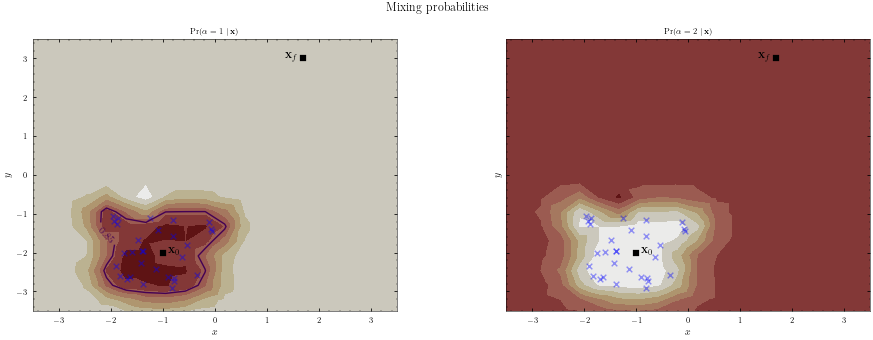

In [22]:
plot_mixing_probs(initial_states)
# plt.savefig("./images/mixing_probs_expanded_step{}.pdf".format(1), transparent=True)
# plot_mixing_probs(initial_states)
# plt.savefig("./images/mixing_probs_with_new_data_step{}.pdf".format(1), transparent=True)

In [23]:
logging_epoch_freq = 30
class PlottingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % logging_epoch_freq == 0:
    #         clear_output(True)
#             plt.figure(figsize=[16, 8])
#             plt.subplot(1, 2, 1)
    #         plt.title("Mean ELBO = %.3f" % -np.mean(np.array(logs['loss'][-32:])))
#             plt.scatter(np.arange(len(logs['loss'])), np.array(logs['loss'])*-1.0)
#             plt.grid()
            plot_mixing_probs(dataset[0])
            save_filename = os.path.join(save_dir,"mixing_probs_expanded_step{}_epoch{}.pdf".format(step, epoch))
            plt.savefig(save_filename, transparent=True)
#             plt.savefig("./images/mixing_probs_expanded_step{}_epoch{}.pdf".format(step, epoch), transparent=True)

In [ ]:
num_steps = 15
num_states_to_sample = 100
# mode_satisfaction_prob = 0.8
dataset = initial_dataset
previous_mosvgpe = None  # used to make sure new samples are in new region
for step in range(1, num_steps):
    new_dataset = sample_delta_mode_remaining_state_control_inputs(dataset, 
                                                                   delta_mode_prob=mode_satisfaction_prob, 
                                                                   previous_mosvgpe=previous_mosvgpe,
                                                                   num_states_to_sample=num_states_to_sample)
    dataset = update_dataset(dataset, new_dataset)
    history = mode_optimiser.dynamics.fit(dataset[0], 
                                          dataset[1], 
                                          epochs=num_epochs, 
                                          batch_size=batch_size, 
                                          verbose=False,
                                          callbacks=PlottingCallback())
#     history = mode_optimiser.dynamics.fit(dataset[0], 
#                                           dataset[1], 
#                                           epochs=30, 
#                                           batch_size=batch_size, 
#                                           verbose=False, 
#                                           callbacks=PlottingCallback())
    
#     plot_mixing_probs(dataset[0])
#     plt.savefig("./images/mixing_probs_expanded_step{}.pdf".format(step), transparent=True)
#     plot_mixing_probs(dataset[0])
#     plt.savefig("./images/mixing_probs_with_new_data_step{}.pdf".format(step), transparent=True)
#     previous_dataset = dataset
    previous_mosvgpe = MixtureOfSVGPExperts.from_config(mode_optimiser.dynamics.mosvgpe.get_config())

Mode satisfaction probability being relaxed to 0.7999999999999999


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape),

Mode satisfaction probability being relaxed to 0.7999999999999999


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape),

Mixing probs: (1, 16, 2)
Experts probs: (1, 16, 2)


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


Mode satisfaction probability being relaxed to 0.7999999999999999


/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,5))
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: No contour levels were found within the data range.
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')
/var/folders/f4/yffwfgvx2mvg3gshpxwtpld40000gn/T/ipykernel_6825/557219647.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  CS = axs[k].contour(xx, yy, mixing_probs[:, k].numpy().reshape(xx.shape), [mode_satisfaction_prob], color='r')


In [ ]:
dataset = update_dataset(dataset, new_dataset)
plot_mixing_probs(dataset[0])

In [ ]:
mode_optimiser.dynamics.fit(dataset[0], dataset[1], epochs=num_epochs, batch_size=batch_size)

In [ ]:
plot_mixing_probs(dataset[0])